# Requirements

In [4]:
!pip install langchain-groq langchain-astradb langchain-core langchain-community


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Product Recommendation by AI

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
#langchain
from langchain_core.documents import Document
from langchain_groq import ChatGroq
from langchain_astradb import AstraDBVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain, create_history_aware_retriever
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
plt.style.use('ggplot')
sns.set(style='darkgrid',palette='dark')

In [28]:
GROQ_API_KEY = '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'
API_ENDPOINT = 'https://2ea48f62-f441-4b37-82a2-5dd32f836c24-us-east-2.apps.astra.datastax.com'
APPLICATION_TOKEN = 'AstraCS:XXcPlHZrlPNNuJcAfLYULYAu:6599dc7aac7c849571b3ca13db80ac90728a96aff9fa8341e730a100ea8e6c02'
KEY_SPACE = 'default_keyspace'

In [35]:
model = ChatGroq(
    model = 'mixtral-8x7b-32768',
    api_key = GROQ_API_KEY,
    temperature=0.4,
    max_tokens = 100 
)

embed_model = HuggingFaceEmbeddings(model_name=r'embedding_model/models--BAAI--bge-base-en-v1.5/snapshots/a5beb1e3e68b9ab74eb54cfd186867f64f240e1a',
                                    #model_kwargs={'device':'cuda'},
                                    encode_kwargs={'normalize_embeddings':True})

C:\Users\gupta\AppData\Local\Programs\Python\Python312\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [36]:
vector_store = AstraDBVectorStore(
    collection_name='first_vs',
    embedding=embed_model,
    api_endpoint=API_ENDPOINT,
    token=APPLICATION_TOKEN,
    namespace=KEY_SPACE
)

In [7]:
df = pd.read_csv('data/flipkart-data.csv')

In [8]:
df = df.copy()
df.sample(5)

,product_id,product_title,rating,summary,review
76,ACCFHGZFS7GB9CVM,realme Buds Wireless Bluetooth Headset,5,Brilliant,Really appreciated this product from realme .....
53,ACCFHGZFS7GB9CVM,realme Buds Wireless Bluetooth Headset,5,Simply awesome,in love with thisthe auto turn off when magnet...
207,ACCFVA3KZ2EYMYX3,OnePlus Bullets Wireless Z Bass Edition Blueto...,4,Value-for-money,1. Call quality is Good. I have tested the cal...
36,ACCFZGAQJGYCYDCM,BoAt Rockerz 235v2 with ASAP charging Version ...,4,Nice product,Review after about 2months of usage.Before sta...
314,ACCFSKBJYWZKXGCP,U&I Titanic Series - Low Price Bluetooth Neckb...,5,Simply awesome,This product is good for daily use. The sound ...


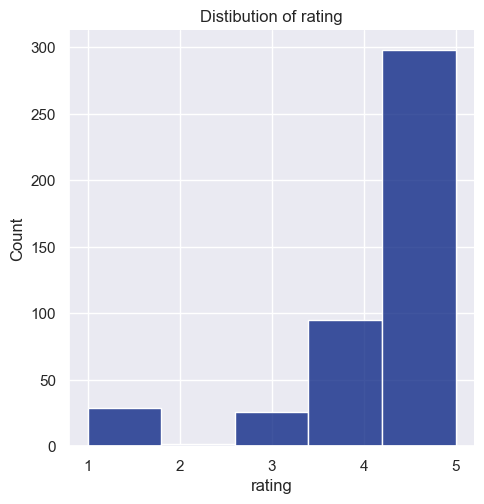

In [9]:
sns.displot(data=df['rating'],bins=5)
plt.title('Distibution of rating')
plt.show()

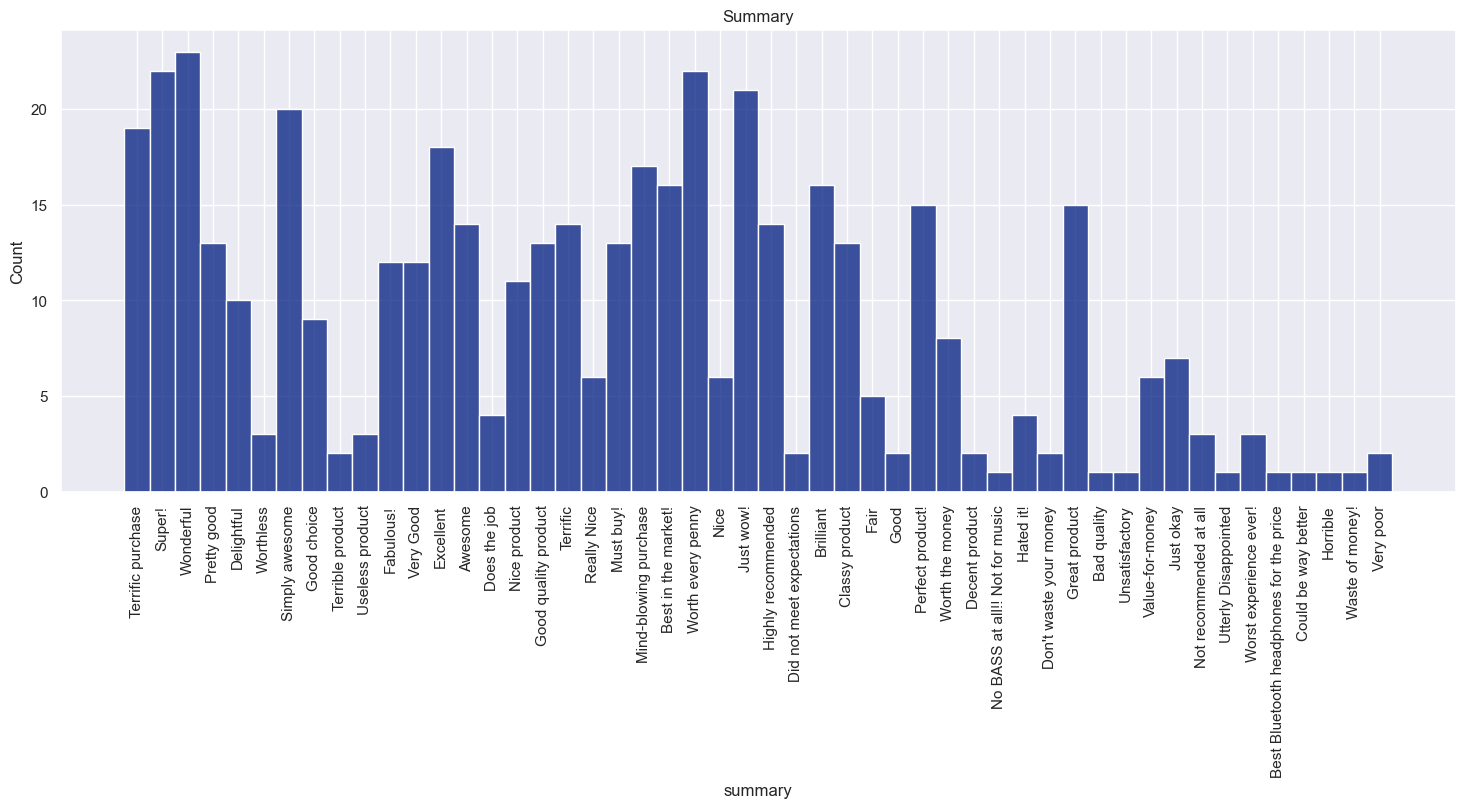

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
sns.histplot(data=df['summary'], ax=ax)
plt.xticks(rotation=90)
plt.title('Summary')
plt.show()

In [11]:
#Convert emoji inot text
def decode_emoji(review):
    text = emoji.demojize(review)
    return text

In [12]:
df['review'] = df['review'].apply(decode_emoji)

In [13]:
product_list = []
for index,row in df.iterrows():
    object = {
        'product_name':row['product_title'],
        'review':row['review']
    }
    product_list.append(object)

In [19]:
docs = []

for content in product_list:
    metadata = {'product_name':content['product_name']}
    page_content = content['review']
    doc = Document(page_content=page_content, metadata=metadata)
    docs.append(doc)

In [37]:
insert_id = vector_store.add_documents(docs)

In [39]:
retriever = vector_store.as_retriever()

In [50]:
retriever_Prompt = (
    "Given the chat history and the lastest user question which might reference context in the chat history,"
    "formulate a standalone question which can be understood without the chat history"
    "Do not answer the question, just reformulate it if needed and otherwise return as it as it"
)

contextualize_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',retriever_Prompt),
        MessagesPlaceholder(variable_name='chat_history'),
        ('user','{input}')
    ]
)

history_aware = create_history_aware_retriever(llm=model,
                                               retriever=retriever,
                                               prompt=contextualize_prompt)

In [56]:
chat_history = []

In [66]:
product_bot_template = """
    you ecommerce bot is an expert in product recommendationsand customer queries.
    it analyzes product titles and reviews to provide accurate and helpful responses.
    ensure your answer are relevant to the product context and refrain from staying off-topic.
    you're response should be concise and informative.
    not use they in your answer
    CONTEXT:{context}
    QUESTION:{input}
    YOUR ANSWER:
"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',product_bot_template),
        MessagesPlaceholder(variable_name='chat_history'),
        ('human','{input}')
    ]
)

qa_chain = create_stuff_documents_chain(llm = model,
                                       prompt = qa_prompt)

In [67]:
rag_chain = create_retrieval_chain(history_aware,qa_chain)

In [68]:
output = rag_chain.invoke({'input':'boat rockerz','chat_history':chat_history})

In [69]:
output['answer']

"Sure, I understand you're a fan of Boat Rockerz earphones! The customer who posted the review is also a long-time Boat user and is satisfied with their new Airdopes, except for the bass which is slightly less than the Rockerz 255. However, they love the auto-connect feature, battery backup, fast charging, attractive design, and comfortable earbuds.\n\nYou mentioned Boat Rockerz, and I'd like"

In [78]:
store = {}
def get_session_history(session_id:str)->BaseChatMessageHistory:
    if session_id not in store:
        store[session_id]=ChatMessageHistory()
    return store[session_id]

In [80]:
chain_with_memory = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key='input',
    history_messages_key='chat_history',
    output_messages_key='answer'
)

In [83]:
chain_with_memory.invoke(
    {'input':'why that bud only you suggest'},
    config = {
        'configurable':{'session_id':'123'}
    }
)

{'input': 'why that bud only you suggest',
 'chat_history': [HumanMessage(content='best buds to buy', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Based on the product titles and reviews provided, the "Best Quality buds" and "Realme buds" with awesome sound quality, superb bass, and a comfortable fit are great options to consider. They have received positive feedback for their sound quality, bass, and fit, with some users noting that they provide a noise-cancelling effect. However, it\'s important to note that some of the products mentioned do not have explicit noise-cancelling features. Nonetheless,', additional_kwargs={}, response_metadata={})],
 'context': [Document(id='7e9b49d35a29429189e2c274a642b779', metadata={'product_name': 'realme Buds Wireless Bluetooth Headset'}, page_content="I'm a music producer and I find this earphones good but it's not worth the price, you can choose one plus instead or infinity by jbl for crystal clear sound quality, real me buds 

In [86]:
store['123']

InMemoryChatMessageHistory(messages=[HumanMessage(content='best buds to buy', additional_kwargs={}, response_metadata={}), AIMessage(content='Based on the product titles and reviews provided, the "Best Quality buds" and "Realme buds" with awesome sound quality, superb bass, and a comfortable fit are great options to consider. They have received positive feedback for their sound quality, bass, and fit, with some users noting that they provide a noise-cancelling effect. However, it\'s important to note that some of the products mentioned do not have explicit noise-cancelling features. Nonetheless,', additional_kwargs={}, response_metadata={}), HumanMessage(content='why that bud only you suggest', additional_kwargs={}, response_metadata={}), AIMessage(content="Based on the product titles and reviews provided, the Realme Buds 2 are suggested due to their impressive sound quality, deep bass, and comfortable fit. They have received positive feedback for their noise-cancelling effect and are 